In [1]:
from func import *
import pandas as pd
import numpy as np


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import string
import re

import spacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc
import numpy
from nltk.corpus import stopwords
import string
import re

### Load the data

In [2]:
df = load_data(data = 'musical')

In [3]:
df.shape

(10261, 9)

In [4]:
X = df['reviewText']
y = df['overall']

### Distribution of the ratings

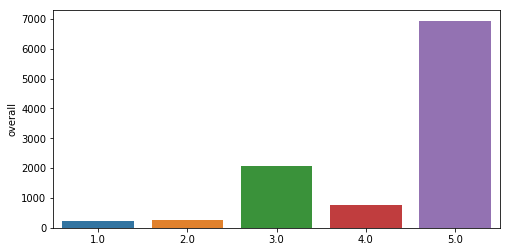

In [5]:
fig = plt.figure(figsize=(8,4))
sns.barplot(x = y.unique(), y=y.value_counts())
plt.show()

### Data Cleaning

In [4]:
def get_top_bottom_n_words(corpus, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    
    get_top_n_words(["I love Python", "Python is a language programming", "Hello world", "I love the world"]) -> 
    [('python', 2),
     ('world', 2),
     ('love', 2),
     ('hello', 1),
     ('is', 1),
     ('programming', 1),
     ('the', 1),
     ('language', 1)]
    """
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n], words_freq[-n:]

In [5]:
freq_words, infreq_words = get_top_bottom_n_words(df['reviewText'], n=100)

In [8]:
def remove_tokens_on_match(doc):
    '''
    remove the punctuation, number and symbols
    and also lemmentize the words
    '''
    indexes = []
    for index, token in enumerate(doc):
        if token.is_stop:
            indexes.append(index)
        if (token.pos_  in ('PUNCT', 'NUM', 'SYM')):
            indexes.append(index)
    np_array = doc.to_array([LOWER, POS, ENT_TYPE, IS_ALPHA])

    np_array = numpy.delete(np_array, indexes, axis = 0)
    doc2 = Doc(doc.vocab, words=[t.lemma_ for i, t in enumerate(doc) if i not in indexes])
    doc2.from_array([LOWER, POS, ENT_TYPE, IS_ALPHA], np_array)
    return doc2

nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
nlp.add_pipe(nlp.create_pipe('sentencizer'))
nlp.add_pipe(remove_tokens_on_match, name="custom_model_wrapper", last=True)

print(nlp.pipe_names)  # ['tagger', 'parser', 'ner', 'print_info']
doc = nlp("This is a 4 sentences running.")
# for token in doc:
#     print(token.lemma_)
print(doc.text)

['tagger', 'sentencizer', 'custom_model_wrapper']
sentence run 


In [7]:
nlp = spacy.load("en_core_web_sm", disable=['ner', 'parser'])
nlp.add_pipe(remove_tokens_on_match, name="custom_model_wrapper", last=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print("Parsing texts...")
train_docs = list(nlp.pipe(X_train))
dev_docs = list(nlp.pipe(X_test))

I1105 21:13:57.605772 4665804224 file_utils.py:39] PyTorch version 1.2.0 available.
I1105 21:13:57.649369 4665804224 modeling_xlnet.py:194] Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex .


Parsing texts...


In [9]:
def get_labelled_sentences(docs, doc_labels):
    '''
    extract the text from the Spacy doc data
    '''
    labels = []
    sentences = []
    for doc, y in zip(docs, doc_labels):
        sentences.append(doc.text)
        labels.append(y)
    return sentences, numpy.asarray(labels, dtype="int32")

In [10]:
train_data, y_train = get_labelled_sentences(train_docs, y_train)
test_data, y_test = get_labelled_sentences(dev_docs, y_test)

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
def get_features(train_data, test_data, n):

    # Initialize a TfidfVectorizer object: tfidf_vectorizer
    tfidf_vectorizer = TfidfVectorizer(lowercase=False, stop_words="english", ngram_range=(1, n), 
                                       max_df=0.99, min_df=0.01)

    # Transform the training data: tfidf_train 
    train_tfidf_df = tfidf_vectorizer.fit_transform(train_data)
    test_tfidf_df = tfidf_vectorizer.transform(test_data)
    return train_tfidf_df, test_tfidf_df

In [56]:
train_feature, test_feature= get_features(train_data, test_data, 2)
# test_feature = get_features(test_data, 2)

In [163]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
n=2
pipe = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=False, stop_words="english", min_df=0.01)),
    ('logistic', LogisticRegression(multi_class='multinomial',solver='sag'))
])

# single categorical value of 'model' parameter is 
# sets the model class
# We will get ConvergenceWarnings because the problem is not well-conditioned.
# But that's fine, this is just an example.
param = {
    'tfidf__max_df': Real(.95, 1, prior='log-uniform'),
#     'tfidf__min_df': Real(0, .1, prior='log-uniform'),
    'tfidf__ngram_range': Categorical([(1, 1), (1, 2)]),
    'logistic__max_iter': Integer(500, 1000),
    'logistic__class_weight': ["balanced", None],
        
                                         
#     'logistic': [LogisticRegression(max_iter=1000)],
    'logistic__C': Real(.5, 1, prior='log-uniform'),
    'logistic__penalty': ['l1', 'l2']
}


opt = BayesSearchCV(
    
    pipe,
    
    search_spaces= [(param, 1)], # (parameter space, # of evaluations)
    cv=3
)

opt.fit(train_data, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(test_data, y_test))

val. score: 0.684990253411306
test score: 0.6792673421667965


In [164]:
best_model =opt.best_estimator_
#.fit(train_data)

In [165]:
best_model.fit(train_data, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=0.9960290455123179, max_features=None,
        min_df=0.01, ngram_range=(1, 1), norm='l2', preprocessor=Non...l2',
          random_state=None, solver='sag', tol=0.0001, verbose=0,
          warm_start=False))])

In [166]:
y_fitted = best_model.predict(train_data)

In [167]:
y_predicted = best_model.predict(test_data)

In [168]:
from mlxtend.evaluate import confusion_matrix


cm = confusion_matrix(y_target=y_test, 
                      y_predicted=y_predicted, 
                      binary=False)
cm

array([[   0,    0,    1,    1,   45],
       [   0,    0,    1,    9,   60],
       [   0,    0,    4,   22,  140],
       [   0,    0,    3,   58,  499],
       [   0,    0,    1,   41, 1681]])

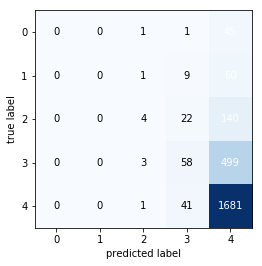

In [169]:
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()